In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import time
from datetime import datetime, timedelta
from topaz import TopazAPI
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import requests
import os
import concurrent.futures
import math
import mapping


In [2]:
from ft_sec_key import SECKEY,TOPAZ, PW
api_key = TOPAZ #Insert your API key 
topaz_api = TopazAPI(api_key)

In [3]:
runs_df = pd.concat([pd.read_feather('server_data/'+x) for x in os.listdir('server_data/')])

C:\Users\Nick\AppData\Local\Temp\ipykernel_15312\31448566.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  runs_df = pd.concat([pd.read_feather('server_data/'+x) for x in os.listdir('server_data/')])


In [4]:
new_pred = pd.read_feather('server_data/new_races_runs.fth')

In [5]:
runs_df.meetingDate.max()

'2024-05-19T00:00:00.000Z'

In [6]:
runs_df.isna().sum()

trackCode              0
track                  0
distance               0
raceId                 0
meetingDate            0
                  ...   
time_2           2693042
position_2       2693042
splitMargin_2    3123651
winMarketId      3123387
selectionId      3123387
Length: 67, dtype: int64

In [7]:
runs_df.raceId.nunique()

352219

In [8]:
runs_df = runs_df.dropna(subset=['place'], how='all')    
runs_df.drop_duplicates(inplace=True)

In [9]:
runs_df = pd.concat([runs_df, new_pred])

In [10]:
runs_df.raceId.nunique()

349437

In [11]:
runs_df.shape

(2527511, 67)

In [12]:
runs_df.columns

Index(['trackCode', 'track', 'distance', 'raceId', 'meetingDate',
       'raceTypeCode', 'raceType', 'runId', 'dogId', 'dogName', 'weightInKg',
       'incomingGrade', 'outgoingGrade', 'gradedTo', 'rating', 'raceNumber',
       'boxNumber', 'boxDrawnOrder', 'rugNumber', 'startPrice', 'place',
       'unplaced', 'unplacedCode', 'scratched', 'prizeMoney', 'resultTime',
       'resultMargin', 'resultMarginLengths', 'startPaceCode', 'jumpCode',
       'runLineCode', 'firstSecond', 'colourCode', 'sex', 'comment', 'ownerId',
       'trainerId', 'ownerName', 'ownerState', 'trainerName', 'trainerSuburb',
       'trainerState', 'trainerDistrict', 'trainerPostCode', 'isQuad',
       'isBestBet', 'damId', 'damName', 'sireId', 'sireName', 'dateWhelped',
       'totalFormCount', 'last5', 'isLateScratching', 'bestTime',
       'bestFinishTrackAndDistance', 'pir', 'careerPrizeMoney', 'averageSpeed',
       'time_1', 'position_1', 'splitMargin_1', 'time_2', 'position_2',
       'splitMargin_2', 'winMa

In [13]:
runs_df.runLineCode.value_counts(dropna=False)

runLineCode
None      1536499
Normal     945339
Wide        37356
Railer       8317
Name: count, dtype: int64

In [14]:
runs_df.startPaceCode.value_counts(dropna=False)

startPaceCode
None    2273243
Fast     192929
Slow      61339
Name: count, dtype: int64

In [15]:
runs_df.startPrice.value_counts(dropna=False)

startPrice
5.00      50584
1.00      45447
6.00      40791
4.00      39220
7.00      34085
          ...  
156.30        1
165.90        1
184.10        1
174.30        1
2.88          1
Name: count, Length: 1851, dtype: int64

In [16]:
runs_df['date'] = pd.to_datetime(runs_df['meetingDate']).dt.date

In [17]:
runs_df['year-month'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('M')
runs_df['year'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('Y')

C:\Users\Nick\AppData\Local\Temp\ipykernel_15312\74229333.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  runs_df['year-month'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('M')
C:\Users\Nick\AppData\Local\Temp\ipykernel_15312\74229333.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  runs_df['year'] = pd.to_datetime(runs_df['meetingDate']).dt.to_period('Y')


In [18]:
runs_df.date.min()

datetime.date(2015, 1, 1)

In [19]:
runs_df.groupby('year')['raceId'].unique().apply(len).value_counts()

raceId
35830    1
36868    1
38038    1
36929    1
36578    1
35348    1
38076    1
38188    1
38982    1
14600    1
Name: count, dtype: int64

In [20]:
# runs_df.to_excel('nz_topaz.xlsx')

In [21]:
TrackDict = {
    'Auckland (NZ)':'Manukau',
    'Christchurch (NZ)':'Addington',
    'Dport @ HOB':'Hobart',
    'Dport @ LCN':'Launceston',
    'Meadows (MEP)':'The Meadows',
    'Otago (NZ)':'Forbury Park',
    'Palmerston Nth (NZ)':'Manawatu',
    'Sandown (SAP)':'Sandown Park',
    'Southland (NZ)':'Ascot Park',
    'Tokoroa (NZ)':'Tokoroa',
    'Waikato (NZ)':'Cambridge',
    'Wanganui (NZ)':'Hatrick',
    'Taranaki (NZ)':'Taranaki',
    'Ashburton (NZ)':'Ashburton',
    'Richmond (RIS)':'Richmond Straight',
    'Murray Bridge (MBR)':'Murray Bridge',
    'Murray Bridge (MBS)':'Murray Bridge Straight'
}

In [22]:
TopazData = runs_df.copy()
TopazData['track'] = TopazData['track'].replace(TrackDict)
TopazData['meetingDate'] = pd.to_datetime(TopazData['meetingDate'])
TopazData['dateWhelped'] = pd.to_datetime(TopazData['dateWhelped'])

TopazData['dogName']=TopazData['dogName'].str.replace("'","")
TopazData['sireName']=TopazData['sireName'].str.replace("'","")
TopazData['damName']=TopazData['damName'].str.replace("'","")

In [23]:
TopazData.raceId.nunique()

349437

In [24]:
state_map = {x['trackName']:x['State'] for x in mapping.trackCodes}

In [25]:
TopazData['state'] = TopazData['track'].map(state_map)

In [26]:
# vicdf = TopazData.query('state  =="VIC"')

In [27]:
# vicdf.runLineCode.value_counts(dropna=False)

In [28]:
TopazData[['state', 'track']].value_counts(sort=False)

state  track                 
NSW    Armidale                    2072
       Bathurst                   33163
       Broken Hill                 9556
       Bulli                      34595
       Canberra                   15018
       Casino                     43716
       Coonabarabran               4010
       Coonamble                   8018
       Cowra                       4662
       Dapto                      37313
       Dubbo                      33891
       Gosford                    37502
       Goulburn                   41070
       Grafton                    42755
       Gunnedah                   23019
       Kempsey                     6833
       Lismore                    25012
       Lithgow                     8117
       Maitland                   36704
       Moree                       5104
       Mudgee                      2628
       Muswellbrook               10269
       Nowra                      33814
       Potts Park                  7811
       Ric

In [29]:
TopazData.state.value_counts()

state
VIC    993242
NSW    862747
SA     279772
NZ      71683
Name: count, dtype: int64

In [30]:
TopazData[TopazData['state'].isna()]['track'].unique()

array(['Ascot Park', 'Cambridge', 'Addington', 'Hatrick', 'Manukau',
       'Wellington (NZ)'], dtype=object)

In [31]:
TopazData['state'] = TopazData['state'].fillna('NZ')

In [32]:
# TopazData = TopazData.query('state == "NZ"')

In [33]:
TopazData = TopazData.sort_values('date').reset_index(drop=True)

In [34]:
TopazData.date

0          2015-01-01
1          2015-01-01
2          2015-01-01
3          2015-01-01
4          2015-01-01
              ...    
2527506    2024-05-19
2527507    2024-05-19
2527508    2024-05-19
2527509    2024-05-19
2527510    2024-05-19
Name: date, Length: 2527511, dtype: object

In [35]:
TopazData.columns

Index(['trackCode', 'track', 'distance', 'raceId', 'meetingDate',
       'raceTypeCode', 'raceType', 'runId', 'dogId', 'dogName', 'weightInKg',
       'incomingGrade', 'outgoingGrade', 'gradedTo', 'rating', 'raceNumber',
       'boxNumber', 'boxDrawnOrder', 'rugNumber', 'startPrice', 'place',
       'unplaced', 'unplacedCode', 'scratched', 'prizeMoney', 'resultTime',
       'resultMargin', 'resultMarginLengths', 'startPaceCode', 'jumpCode',
       'runLineCode', 'firstSecond', 'colourCode', 'sex', 'comment', 'ownerId',
       'trainerId', 'ownerName', 'ownerState', 'trainerName', 'trainerSuburb',
       'trainerState', 'trainerDistrict', 'trainerPostCode', 'isQuad',
       'isBestBet', 'damId', 'damName', 'sireId', 'sireName', 'dateWhelped',
       'totalFormCount', 'last5', 'isLateScratching', 'bestTime',
       'bestFinishTrackAndDistance', 'pir', 'careerPrizeMoney', 'averageSpeed',
       'time_1', 'position_1', 'splitMargin_1', 'time_2', 'position_2',
       'splitMargin_2', 'winMa

In [36]:
TopazData.raceId

0          1113980019
1          1092870521
2          1092870521
3          1092870521
4          1092870521
              ...    
2527506    1034594565
2527507    1034594565
2527508    1034594565
2527509    1034594566
2527510    1034651675
Name: raceId, Length: 2527511, dtype: int64

In [37]:
TopazData['pir'].str.replace('[A-z]','',regex=True).fillna(0).astype(str)

0          7654
1           222
2           876
3           535
4           444
           ... 
2527506       0
2527507       0
2527508       0
2527509       0
2527510       0
Name: pir, Length: 2527511, dtype: object

In [38]:
TopazData['pir'].str.replace('[A-z]','',regex=True).fillna(0).astype(str).value_counts(dropna=False).head(10)

pir
0       266804
111      77546
11       46936
222      38274
22       33015
888      26252
1111     26211
33       25419
333      24289
777      23160
Name: count, dtype: int64

In [39]:
TopazData.incomingGrade.value_counts(dropna=False)

incomingGrade
5         986444
Maiden    424961
7         366355
6         277158
4         205132
3          99884
2          86108
1          81469
Name: count, dtype: int64

In [40]:
TopazData['incomingGrade_val'] = TopazData['incomingGrade'].str.replace('Maiden','8').fillna(0).astype(int)

In [41]:
TopazData['incomingGrade_val'].value_counts(dropna=False)

incomingGrade_val
5    986444
8    424961
7    366355
6    277158
4    205132
3     99884
2     86108
1     81469
Name: count, dtype: int64

In [42]:
#Filter out some of the races with bad data
TopazData = TopazData.query('resultTime > 10')
TopazData['averageSpeed'] = TopazData['distance'] / TopazData['resultTime']
TopazData = TopazData.query('averageSpeed > 11 and averageSpeed < 22')

In [43]:
TopazData.query('resultTime < 10')

,trackCode,track,distance,raceId,meetingDate,raceTypeCode,raceType,runId,dogId,dogName,...,time_2,position_2,splitMargin_2,winMarketId,selectionId,date,year-month,year,state,incomingGrade_val


In [44]:
backup = TopazData.copy()

In [45]:
TopazData = backup.copy()

In [46]:
# TopazData['last5'] = TopazData['last5'].astype(str)
scaler = MinMaxScaler()
# stop
# # Convert the 'pir' column to string
try:
    TopazData['pir'] = TopazData['pir'].str.replace('[A-z]','',regex=True).fillna(0)
    TopazData['pir'] = TopazData['pir'].astype(str)
except ValueError as e:
    print('Error converting pir to string')
    print(e)
    TopazData['pir'] = '000'

# # Extract the second last letter and create a new column '2ndLastPIR'

TopazData['2ndLastPIR'] = TopazData['pir'].apply(lambda x: x[-2] if len(x) >= 2 else None)
TopazData['2ndLastPIR'].fillna(TopazData['place'],inplace=True)
TopazData['2ndLastPIR'] = TopazData['2ndLastPIR'].astype(int)

# # Create a feature that calculates places gained/conceded in the home straight
TopazData['finishingPlaceMovement'] = TopazData['2ndLastPIR'] - TopazData['place']

TopazData['StartingPlaceMovement'] = TopazData['pir'].apply(lambda x: int(x[0]) if x else None)
TopazData['performance_to_price'] = np.abs(np.log(1 / TopazData['startPrice']) * (1 / (TopazData['place']-0.2)**2))
TopazData['performance_to_price'] = TopazData['performance_to_price'].replace([np.inf, -np.inf], 0).fillna(0)

TopazData['weightInKgScaled'] = TopazData.groupby('raceId')['weightInKg'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten() if x.nunique() > 1 else 0)
# TopazData['weightInKgScaled'] = TopazData.groupby('raceId')['weightInKg'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten() if x.nunique() > 1 else 0)
#Scale values as required
TopazData['prizemoneyLog'] = np.log10(TopazData['prizeMoney'] + 1)
TopazData['placeLog'] = np.log10(TopazData['place'] + 1)
TopazData['marginLog'] = np.log10(TopazData['resultMargin'] + 1)

# Calculate median winner time per track/distance
win_results = TopazData[TopazData['place'] == 1]
grouped_data = win_results.groupby(['track', 'distance', 'meetingDate'])['resultTime'].median().reset_index()
median_win_time = pd.DataFrame(grouped_data.groupby(['track', 'distance']).apply(lambda x: x.sort_values('meetingDate').set_index('meetingDate')['resultTime'].shift(1).rolling('365D', min_periods=1).median())).reset_index()
median_win_time.rename(columns={"resultTime": "runTimeMedian"},inplace=True)
median_win_time['speedIndex'] = (median_win_time['runTimeMedian'] / median_win_time['distance'])
median_win_time['speedIndex'] = StandardScaler().fit_transform(median_win_time[['speedIndex']])
TopazData = TopazData.merge(median_win_time, how='left', on=['track', 'distance','meetingDate'])
TopazData['runTimeNorm'] = (TopazData['resultTime']/TopazData['runTimeMedian']).clip(0.8, 1.2)
TopazData['runTimeNorm'] = StandardScaler().fit_transform(TopazData[['runTimeNorm']])

win_results = TopazData[TopazData['place'] == 1][['raceId','runTimeNorm']]
win_results.rename(columns={'runTimeNorm':'win_runTimeNorm'},inplace=True)
TopazData = TopazData.merge(win_results, on='raceId')
TopazData['delta_win_runTimeNorm'] = TopazData['runTimeNorm'] - TopazData['win_runTimeNorm']


#Same for split time
split_win_results = TopazData[TopazData['position_1'] == 1]
grouped_data = split_win_results.groupby(['track', 'distance', 'meetingDate'])['time_1'].median().reset_index()
median_split_win_time = pd.DataFrame(grouped_data.groupby(['track', 'distance']).apply(lambda x: x.sort_values('meetingDate').set_index('meetingDate')['time_1'].shift(1).rolling('365D', min_periods=1).median())).reset_index()
median_split_win_time.rename(columns={'time_1': 'split_time_median'},inplace=True)
median_split_win_time['split_speedIndex'] = median_split_win_time['split_time_median']
median_split_win_time['split_speedIndex'] = StandardScaler().fit_transform(median_split_win_time[['split_time_median']])
TopazData = TopazData.merge(median_split_win_time, how='left', on=['track', 'distance','meetingDate'])
TopazData['split_runTimeNorm'] = (TopazData['split_time_median'] / TopazData['time_1']).clip(0.8, 1.2)
TopazData['split_runTimeNorm'] = StandardScaler().fit_transform(TopazData[['split_runTimeNorm']])
min_run_time = TopazData.groupby('raceId')[['time_1']].min().reset_index().rename(columns={'time_1':'min_run_time'})
TopazData = TopazData.merge(min_run_time, on='raceId')
TopazData['split_time_margin'] = TopazData['time_1']-TopazData['min_run_time']

# Same for runhome time
TopazData['run_home_time'] = TopazData['resultTime'] - TopazData['time_1']
win_results = TopazData[TopazData['place'] == 1]
grouped_data = win_results.groupby(['track', 'distance', 'meetingDate'])['run_home_time'].median().reset_index()
median_win_time = pd.DataFrame(grouped_data.groupby(['track', 'distance']).apply(lambda x: x.sort_values('meetingDate').set_index('meetingDate')['run_home_time'].shift(1).rolling('365D', min_periods=1).median())).reset_index()
median_win_time.rename(columns={'run_home_time': "run_home_TimeMedian"},inplace=True)
median_win_time['run_home_speedIndex'] = (median_win_time['run_home_TimeMedian'] / median_win_time['distance'])
median_win_time['run_home_speedIndex'] = StandardScaler().fit_transform(median_win_time[['run_home_speedIndex']])
TopazData = TopazData.merge(median_win_time, how='left', on=['track', 'distance','meetingDate'])
TopazData['run_home_TimeNorm'] = (TopazData['run_home_TimeMedian'] / TopazData['run_home_time']).clip(0.8, 1.2)
TopazData['run_home_TimeNorm'] = StandardScaler().fit_transform(TopazData[['runTimeNorm']])

# Sort the DataFrame by 'RaceId' and 'Box'
TopazData = TopazData.sort_values(by=['raceId', 'boxNumber'])

# Check if there is an entry equal to boxNumber + 1
TopazData['hasEntryBoxNumberPlus1'] = (TopazData.groupby('raceId')['boxNumber'].shift(1) == TopazData['boxNumber'] + 1) | (TopazData['boxNumber'] == 8)
TopazData['hasEntryBoxNumberMinus1'] = (TopazData.groupby('raceId')['boxNumber'].shift(-1) == TopazData['boxNumber'] - 1)
# Convert boolean values to 1
TopazData['hasEntryBoxNumberPlus1'] = TopazData['hasEntryBoxNumberPlus1'].astype(int)
TopazData['hasEntryBoxNumberMinus1'] = TopazData['hasEntryBoxNumberMinus1'].astype(int)
# Display the resulting DataFrame which shows adjacent Vacant Boxes
# Box 1 is treated as having a vacant box to the left always as we are looking how much space the dog has to move.
TopazData['adjacentVacantBoxes'] = 2 - TopazData['hasEntryBoxNumberPlus1'] - TopazData['hasEntryBoxNumberMinus1']
# Calculate 'hasAtLeast1VacantBox'
TopazData['hasAtLeast1VacantBox'] = (TopazData['adjacentVacantBoxes'] > 0).astype(int)



TopazData['win'] = TopazData['place'].apply(lambda x: 1 if x == 1 else 0)

grouped_data = TopazData.groupby(['track', 'distance', 'boxNumber', 'hasAtLeast1VacantBox', 'meetingDate'])['win'].mean().reset_index()
grouped_data.set_index('meetingDate', inplace=True)

# Apply rolling mean calculation to the aggregated data
box_win_percent = grouped_data.groupby(['track', 'distance', 'boxNumber', 'hasAtLeast1VacantBox']).apply(lambda x: x.sort_values('meetingDate')['win'].shift(1).rolling('365D', min_periods=1).mean()).reset_index()

# Reset index and rename columns
box_win_percent.columns = ['track', 'distance', 'boxNumber', 'hasAtLeast1VacantBox', 'meetingDate', 'rolling_box_win_percentage']

# Add to dog results dataframe
TopazData = TopazData.merge(box_win_percent, on=['track', 'distance', 'meetingDate','boxNumber','hasAtLeast1VacantBox'], how='left')

# resultMargin has the same value for 1st and 2nd placed dogs, but should be 0 for the 1st placed dog.
TopazData.loc[TopazData['place'] == 1, ['resultMargin']] = 0

TopazData['dogAge'] = (TopazData['meetingDate'] - TopazData['dateWhelped']).dt.days
scaler = MinMaxScaler()
TopazData['dogAgeScaled'] = TopazData.groupby('raceId')['dogAge'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
TopazData['averageSpeed'] = TopazData['distance'] / TopazData['resultTime']

In [47]:
TopazData.speedIndex

0          0.391841
1          0.391841
2          0.391841
3          0.391841
4          0.391841
             ...   
2543670   -0.619928
2543671   -0.619928
2543672   -0.619928
2543673   -0.619928
2543674   -0.619928
Name: speedIndex, Length: 2543675, dtype: float64

In [48]:
TopazData['averageSpeed'] = TopazData['distance'] / TopazData['resultTime']

In [49]:
TopazData['averageSpeed'].describe()

count    2.543675e+06
mean     1.703582e+01
std      3.986826e-01
min      1.114271e+01
25%      1.679165e+01
50%      1.705060e+01
75%      1.729904e+01
max      2.185430e+01
Name: averageSpeed, dtype: float64

In [50]:
520/17

30.58823529411765

<Axes: ylabel='Frequency'>

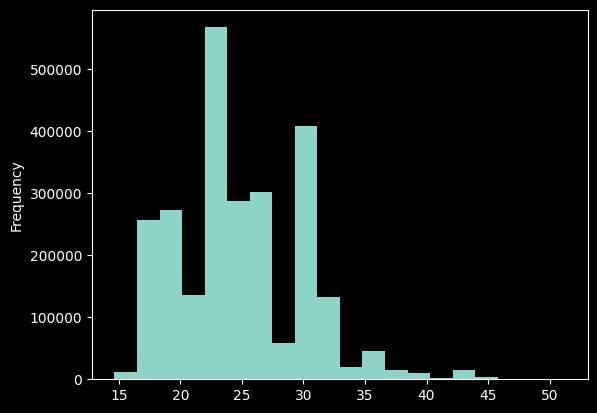

In [51]:
TopazData['resultTime'].plot.hist(bins=20)


<Axes: ylabel='Frequency'>

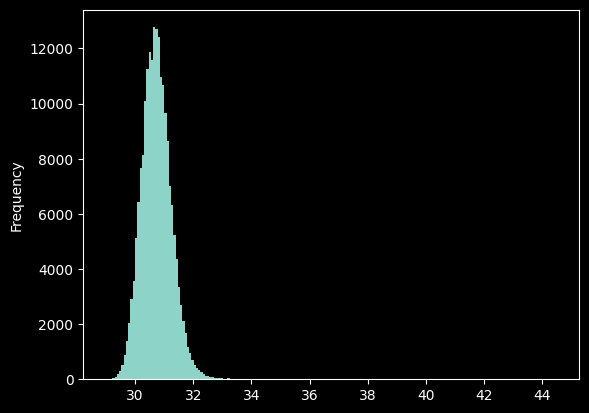

In [52]:
TopazData.query('distance == 520')['resultTime'].plot.hist(bins=200)

<Axes: ylabel='Frequency'>

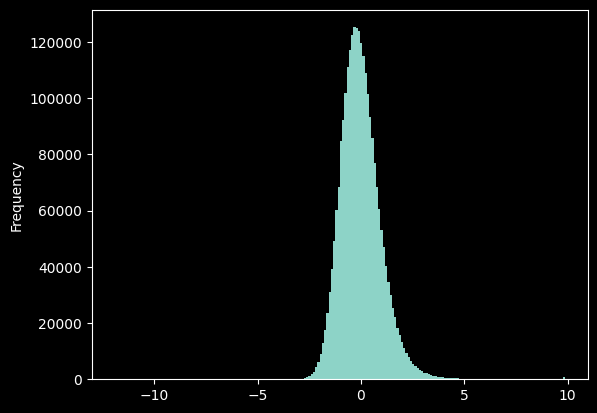

In [53]:
TopazData['runTimeNorm'].plot.hist(bins=200)

<Axes: ylabel='Frequency'>

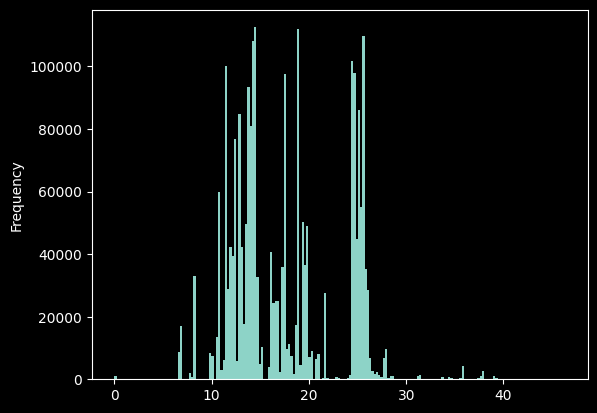

In [54]:
TopazData['run_home_TimeMedian'].plot.hist(bins=200)

In [55]:
TopazData['runTimeNorm']

0         -1.289922
1          0.227380
2          1.011319
3          0.834300
4         -0.379541
             ...   
2543670   -0.679087
2543671   -1.003368
2543672   -1.060594
2543673   -1.229888
2543674   -2.038207
Name: runTimeNorm, Length: 2543675, dtype: float64

In [56]:
TopazData.query('runTimeNorm == 1').to_csv('highruntime.csv')

In [57]:
highruntime = TopazData.query('runTimeNorm == 1')

<Axes: ylabel='Frequency'>

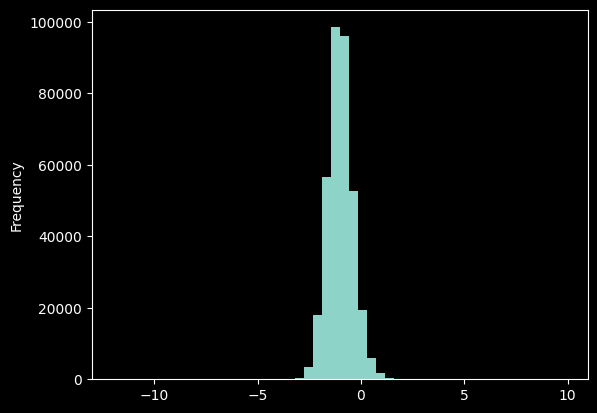

In [58]:
win_results = TopazData[TopazData['place'] == 1][['raceId','runTimeNorm']]
win_results.runTimeNorm.plot.hist(bins=50)

In [59]:
win_results.runTimeNorm.max()

9.89201214492499

In [60]:
TopazData

,trackCode,track,distance,raceId,meetingDate,raceTypeCode,raceType,runId,dogId,dogName,...,run_home_speedIndex,run_home_TimeNorm,hasEntryBoxNumberPlus1,hasEntryBoxNumberMinus1,adjacentVacantBoxes,hasAtLeast1VacantBox,win,rolling_box_win_percentage,dogAge,dogAgeScaled
0,SLE,Sale,650,-2147337285,2016-04-08 00:00:00+00:00,RW,Restricted Win,-2147327190,409540106,BUREKUP JACK,...,1.082962,-1.289033,0,0,2,1,1,0.235294,1058.0,0.839286
1,SLE,Sale,650,-2147337285,2016-04-08 00:00:00+00:00,RW,Restricted Win,-2147327192,794590009,GALLOPING EMMA,...,1.082962,0.228528,0,0,2,1,0,0.161111,776.0,0.000000
2,SLE,Sale,650,-2147337285,2016-04-08 00:00:00+00:00,RW,Restricted Win,-2147327188,237000025,DIEGONATOR,...,1.082962,1.012601,0,0,2,1,0,0.151515,1112.0,1.000000
3,SLE,Sale,650,-2147337285,2016-04-08 00:00:00+00:00,RW,Restricted Win,-2147327193,744220085,POPPY JAY,...,1.082962,0.835552,0,0,2,1,0,0.109375,818.0,0.125000
4,SLE,Sale,650,-2147337285,2016-04-08 00:00:00+00:00,RW,Restricted Win,-2147327191,763790069,LEOPARDSTOWN,...,1.082962,-0.378496,0,0,2,1,0,0.045455,827.0,0.151786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543670,WGL,Warragul,400,2147330092,2024-02-24 00:00:00+00:00,5F,Grade 5 Final,2147340371,593955548,HARD ON ME,...,-0.778988,-0.678093,0,0,2,1,0,0.111146,1359.0,0.836412
2543671,WGL,Warragul,400,2147330092,2024-02-24 00:00:00+00:00,5F,Grade 5 Final,2147340370,798035897,IRISH NIKKI,...,-0.778988,-1.002430,0,0,2,1,0,0.127809,725.0,0.000000
2543672,WGL,Warragul,400,2147330092,2024-02-24 00:00:00+00:00,5F,Grade 5 Final,2147340375,636719900,RILEY COIN,...,-0.778988,-1.059666,0,0,2,1,0,0.127579,1220.0,0.653034
2543673,WGL,Warragul,400,2147330092,2024-02-24 00:00:00+00:00,5F,Grade 5 Final,2147340376,546237800,CLASSY KAYLA,...,-0.778988,-1.228989,0,0,2,1,0,0.128751,1483.0,1.000000


In [61]:
TopazData['averageSpeed'] = TopazData['distance'] / TopazData['resultTime']
TopazData['splitMargin_1'] = np.where(TopazData['position_1'] == 1, 0, TopazData['splitMargin_1'])
TopazData['margin_from_lengths'] = pd.to_numeric(TopazData['resultMarginLengths'].str.replace('L',''))
# TopazData['win']

In [62]:
TopazData['resultMargin'] = TopazData['margin_from_lengths']

In [63]:
TopazData.shape

(2543675, 103)

In [64]:
TopazData.margin_from_lengths

0           5.00
1          15.75
2          24.00
3          22.00
4           9.50
           ...  
2543670     9.75
2543671     7.75
2543672     7.25
2543673     6.25
2543674     1.25
Name: margin_from_lengths, Length: 2543675, dtype: float64

In [65]:
TopazData.date.max()

datetime.date(2024, 5, 19)

In [66]:
TopazData.date.min()

datetime.date(2015, 1, 1)

In [67]:
def rolling_last(x):
    return x.iloc[-1]

In [68]:
import itertools

dataset = TopazData.copy()
print(f"dataset shape: {dataset.shape}")
dataset['meetingDate'] = pd.to_datetime(dataset['meetingDate'])

# Calculate values for dog, trainer, dam and sire
subsets = ['dog', 'trainer', 'dam', 'sire']
# subsets = ['dog']

# Use rolling window of 28, 91 and 365 days
# rolling_windows = ['28D','91D', '365D']
rolling_windows = [1,'28D','91D', '365D']
rolling_windows = [1,'365D']
# rolling_windows = [1]

# Features to use for rolling windows calculation
# features = ['distance','boxNumber','runTimeNorm', 'placeLog', 'prizemoneyLog', 
#             'marginLog','finishingPlaceMovement','splitMargin_1','split_runTimeNorm','run_home_TimeNorm','finishingPlaceMovement',
#             'time_1','averageSpeed']

features = ['distance','boxNumber','runTimeNorm', 'place', 'resultMargin',
            'split_time_margin','split_runTimeNorm','time_1','run_home_TimeNorm','finishingPlaceMovement',
            'averageSpeed', 'win']

features = ['incomingGrade_val','startPrice','distance','boxNumber','runTimeNorm','win_runTimeNorm','delta_win_runTimeNorm','place','resultMargin','finishingPlaceMovement','StartingPlaceMovement',
            'averageSpeed', 'win']

features = ['incomingGrade_val','startPrice','distance','boxNumber','runTimeNorm','win_runTimeNorm','delta_win_runTimeNorm','place','resultMargin','finishingPlaceMovement','StartingPlaceMovement',
            'split_time_margin','split_runTimeNorm','time_1','run_home_TimeNorm','performance_to_price',
            'averageSpeed', 'win']

# dam_features = ['distance','boxNumber','runTimeNorm', 'place', 'resultMargin','split_time_margin','split_runTimeNorm',
#             'time_1','averageSpeed', 'win']


# Aggregation functions to apply

aggregates = ['mean']

# Keep track of generated feature names
feature_cols = []

for i in subsets:
    # Generate rolling window features
    idnumber = i + 'Id'

    subset_dataframe = dataset[['meetingDate',idnumber] + features]
    average_df = pd.DataFrame()

    for feature in features:
        # Group by 'damId' and 'meetingDate' and calculate the average of the current feature
        feature_average_df = subset_dataframe.groupby([idnumber, 'meetingDate'])[feature].mean().reset_index()
        # Rename the feature column to indicate it's the average of that feature
        feature_average_df.rename(columns={feature: f'{feature}{i}DayAverage'}, inplace=True)

        # If average_df is empty, assign the feature_average_df to it
        if average_df.empty:
            average_df = feature_average_df
        else:
            # Otherwise, merge feature_average_df with average_df
            average_df = pd.merge(average_df, feature_average_df, on=[idnumber, 'meetingDate'],how='left')

        # Assuming df is your DataFrame
    column_names = average_df.columns.tolist()
    # Columns to exclude
    columns_to_exclude = [idnumber,'meetingDate']
    # Exclude specified columns from the list
    column_names_filtered = [col for col in column_names if col not in columns_to_exclude]

    average_df.drop_duplicates(inplace=True)
    average_df['meetingDate'] = pd.to_datetime(average_df['meetingDate'])
    average_df = average_df.set_index([idnumber, 'meetingDate']).sort_index() 


    #Process Dog Stats
    for rolling_window in rolling_windows:
        print(f"dataset shape: {dataset.shape}")
        print(f'Processing {i} rolling window {rolling_window} days')

        rolling_result = (
            average_df
            .reset_index(level=0)
            .groupby(idnumber)[column_names_filtered]
            .rolling(rolling_window)  # Use timedelta for rolling window
            .agg(aggregates)
            .groupby(level=0)
            .shift(1)
        )

        # Generate list of rolling window feature names (eg: RunTime_norm_min_365D)
        agg_features_cols = [f'{i}_{f}_{a}_{rolling_window}' for f, a in itertools.product(features, aggregates)]
        # Add features to dataset
        average_df[agg_features_cols] = rolling_result
        # Keep track of generated feature names
        feature_cols.extend(agg_features_cols)
        average_df.fillna(0, inplace=True)

    

    average_df.reset_index(inplace=True)
    dataset = pd.merge(dataset,average_df,on=[idnumber, 'meetingDate'],how='left')

# Only keep data 12 months after the start date of your dataset since we've used a 365D rolling timeframe for some features
# feature_cols = np.unique(feature_cols).tolist()
# dataset = dataset[dataset['meetingDate'] >= '2021-01-01']

dataset = dataset[[
                'meetingDate',
                'state',
                'track',
                'distance',
                'raceId',
                'raceTypeCode',
                'raceNumber',
                'boxNumber',
                'rugNumber',
                'runId',
                'dogId',
                'dogName',
                'weightInKg',
                'sex',
                'trainerId',
                'trainerState',
                'damId',
                'damName',
                'sireId',
                'sireName',
                'win',
                'place',
                'resultTime',
                'resultMargin',
                'resultMarginLengths',
                'dogAgeScaled',
                'startPrice',
                'incomingGrade_val',
                # 'lastFiveWinPercentage',
                # 'lastFivePlacePercentage',
                'weightInKgScaled',
                'rolling_box_win_percentage',
                'hasEntryBoxNumberPlus1', 
                'hasEntryBoxNumberMinus1',]
                 + feature_cols
                ]

feature_cols.extend(['dogAgeScaled',
                     'boxNumber',
                     'incomingGrade_val',

                # 'lastFiveWinPercentage',
                # 'lastFivePlacePercentage',
                'weightInKgScaled',
                'hasEntryBoxNumberPlus1', 'hasEntryBoxNumberMinus1',
                'rolling_box_win_percentage'])

#The below line will output your dataframe to a csv but may be too large to open in Excel.
#dataset.to_csv('testing.csv',index=False)

dataset shape: (2543675, 103)
dataset shape: (2543675, 103)
Processing dog rolling window 1 days
dataset shape: (2543675, 103)
Processing dog rolling window 365D days
dataset shape: (2543675, 157)
Processing trainer rolling window 1 days
dataset shape: (2543675, 157)
Processing trainer rolling window 365D days
dataset shape: (2543675, 211)
Processing dam rolling window 1 days
dataset shape: (2543675, 211)
Processing dam rolling window 365D days
dataset shape: (2543675, 265)
Processing sire rolling window 1 days
dataset shape: (2543675, 265)
Processing sire rolling window 365D days


In [69]:
feature_cols = ['dogAgeScaled',
                     'boxNumber',
                     'incomingGrade_val',
                # 'lastFiveWinPercentage',
                # 'lastFivePlacePercentage',
                'weightInKgScaled',
                'hasEntryBoxNumberPlus1', 'hasEntryBoxNumberMinus1',
                'rolling_box_win_percentage'] + [x for x in feature_cols if (('dog' in x) and ('_1' in x)) or (('dog' not in x) and ('_365' in x))]
feature_cols

['dogAgeScaled',
 'boxNumber',
 'incomingGrade_val',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_incomingGrade_val_mean_1',
 'dog_startPrice_mean_1',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_win_runTimeNorm_mean_1',
 'dog_delta_win_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_StartingPlaceMovement_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_performance_to_price_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'dog_time_1_mean_365D',
 'trainer_incomingGrade_val_mean_365D',
 'trainer_startPrice_mean_365D',
 'trainer_distance_mean_365D',
 'trainer_boxNumber_mean_365D',
 'trainer_runTimeNorm_mean_365D',
 'trainer_win_runTimeNorm_mean_365D',
 'trainer_delta_win_runTimeNorm_mean_365D',
 'trainer_place_mean_365D',
 'tr

In [129]:
feature_cols =['dogAgeScaled',
 'boxNumber',
 'incomingGrade_val',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_incomingGrade_val_mean_1',
 'dog_startPrice_mean_1',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_win_runTimeNorm_mean_1',
 'dog_delta_win_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_StartingPlaceMovement_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_performance_to_price_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'trainer_incomingGrade_val_mean_365D',
 'trainer_startPrice_mean_365D',
 'trainer_distance_mean_365D',
 'trainer_boxNumber_mean_365D',
 'trainer_runTimeNorm_mean_365D',
 'trainer_win_runTimeNorm_mean_365D',
 'trainer_delta_win_runTimeNorm_mean_365D',
 'trainer_place_mean_365D',
 'trainer_resultMargin_mean_365D',
 'trainer_finishingPlaceMovement_mean_365D',
 'trainer_StartingPlaceMovement_mean_365D',
 'trainer_split_time_margin_mean_365D',
 'trainer_split_runTimeNorm_mean_365D',
 'trainer_time_1_mean_365D',
 'trainer_run_home_TimeNorm_mean_365D',
 'trainer_performance_to_price_mean_365D',
 'trainer_averageSpeed_mean_365D',
 'trainer_win_mean_365D',
 'dam_incomingGrade_val_mean_365D',
 'dam_startPrice_mean_365D',
 'dam_distance_mean_365D',
 'dam_boxNumber_mean_365D',
 'dam_runTimeNorm_mean_365D',
 'dam_win_runTimeNorm_mean_365D',
 'dam_delta_win_runTimeNorm_mean_365D',
 'dam_place_mean_365D',
 'dam_resultMargin_mean_365D',
 'dam_finishingPlaceMovement_mean_365D',
 'dam_StartingPlaceMovement_mean_365D',
 'dam_split_time_margin_mean_365D',
 'dam_split_runTimeNorm_mean_365D',
 'dam_time_1_mean_365D',
 'dam_run_home_TimeNorm_mean_365D',
 'dam_performance_to_price_mean_365D',
 'dam_averageSpeed_mean_365D',
 'dam_win_mean_365D',
 'sire_incomingGrade_val_mean_365D',
 'sire_startPrice_mean_365D',
 'sire_distance_mean_365D',
 'sire_boxNumber_mean_365D',
 'sire_runTimeNorm_mean_365D',
 'sire_win_runTimeNorm_mean_365D',
 'sire_delta_win_runTimeNorm_mean_365D',
 'sire_place_mean_365D',
 'sire_resultMargin_mean_365D',
 'sire_finishingPlaceMovement_mean_365D',
 'sire_StartingPlaceMovement_mean_365D',
 'sire_split_time_margin_mean_365D',
 'sire_split_runTimeNorm_mean_365D',
 'sire_time_1_mean_365D',
 'sire_run_home_TimeNorm_mean_365D',
 'sire_performance_to_price_mean_365D',
 'sire_averageSpeed_mean_365D',
 'sire_win_mean_365D']

In [131]:
single_dog = dataset.query('dogId == 409540106')
single_dog

,meetingDate,state,track,distance,raceId,raceTypeCode,raceNumber,boxNumber,rugNumber,runId,...,sire_finishingPlaceMovement_mean_365D,sire_StartingPlaceMovement_mean_365D,sire_split_time_margin_mean_365D,sire_split_runTimeNorm_mean_365D,sire_time_1_mean_365D,sire_run_home_TimeNorm_mean_365D,sire_performance_to_price_mean_365D,sire_averageSpeed_mean_365D,sire_win_mean_365D,date
0,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,1.0,1,-2147327190,...,-0.059917,3.960324,0.203967,-0.032701,7.215603,0.092605,0.444636,16.977764,0.125785,2016-04-08
78290,2016-07-20 00:00:00+00:00,VIC,The Meadows,600,135714891,5,9,4.0,4,135715419,...,-0.045438,4.011305,0.204143,-0.063138,7.227302,0.091414,0.442642,16.967502,0.124799,2016-07-20
84297,2016-07-27 00:00:00+00:00,VIC,Cranbourne,699,137740448,RW,6,1.0,1,137741100,...,-0.046599,4.020776,0.206084,-0.066578,7.224257,0.092701,0.441097,16.966261,0.124360,2016-07-27
107356,2016-08-28 00:00:00+00:00,VIC,Sale,650,147290998,RW,5,3.0,3,147291536,...,-0.038798,4.019468,0.209353,-0.081136,7.244756,0.096105,0.438853,16.962281,0.125215,2016-08-28
110543,2016-09-03 00:00:00+00:00,VIC,Traralgon,595,149013437,SH,5,6.0,6,149013984,...,-0.038912,4.017907,0.209342,-0.082826,7.241885,0.097820,0.439038,16.961110,0.125411,2016-09-03
124103,2016-09-12 00:00:00+00:00,VIC,Traralgon,665,151806012,RW,6,7.0,7,151806568,...,-0.037661,4.013371,0.209275,-0.086796,7.240740,0.100215,0.438821,16.959282,0.125969,2016-09-12
128721,2016-09-25 00:00:00+00:00,VIC,Sale,650,155626133,S,6,5.0,5,155626651,...,-0.030794,4.013762,0.210895,-0.091385,7.244412,0.103878,0.441269,16.956983,0.126885,2016-09-25
133237,2016-10-01 00:00:00+00:00,VIC,Traralgon,525,157423242,S,4,7.0,7,157423956,...,-0.027058,4.016281,0.211197,-0.094479,7.241532,0.105583,0.440049,16.956561,0.126437,2016-10-01
145622,2016-10-16 00:00:00+00:00,VIC,Sale,520,161894154,X45,6,8.0,8,161894759,...,-0.021857,4.017320,0.214494,-0.103575,7.253285,0.105118,0.438630,16.956144,0.126739,2016-10-16
149376,2016-10-22 00:00:00+00:00,VIC,Traralgon,595,163357585,X45,6,1.0,1,163358258,...,-0.016185,4.026506,0.215426,-0.108139,7.252350,0.102503,0.439214,16.957133,0.127197,2016-10-22


In [132]:
dataset

,meetingDate,state,track,distance,raceId,raceTypeCode,raceNumber,boxNumber,rugNumber,runId,...,sire_finishingPlaceMovement_mean_365D,sire_StartingPlaceMovement_mean_365D,sire_split_time_margin_mean_365D,sire_split_runTimeNorm_mean_365D,sire_time_1_mean_365D,sire_run_home_TimeNorm_mean_365D,sire_performance_to_price_mean_365D,sire_averageSpeed_mean_365D,sire_win_mean_365D,date
0,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,1.0,1,-2147327190,...,-0.059917,3.960324,0.203967,-0.032701,7.215603,0.092605,0.444636,16.977764,0.125785,2016-04-08
1,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,2.0,2,-2147327192,...,0.154762,4.803571,0.156080,-0.476336,3.598878,0.546559,0.286484,16.858200,0.051587,2016-04-08
2,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,3.0,3,-2147327188,...,0.379889,4.671080,0.251667,-0.303858,7.497239,-0.019666,0.420547,16.966356,0.112249,2016-04-08
3,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,4.0,4,-2147327193,...,0.015382,3.715544,0.173547,-0.015905,6.887564,0.030713,0.500516,17.049745,0.178975,2016-04-08
4,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,6.0,6,-2147327191,...,0.379889,4.671080,0.251667,-0.303858,7.497239,-0.019666,0.420547,16.966356,0.112249,2016-04-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543670,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,4.0,4,2147340371,...,-0.077472,3.700064,0.174934,0.149201,6.769653,-0.028266,0.482444,17.175105,0.146637,2024-02-24
2543671,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,5.0,5,2147340370,...,0.120645,3.970329,0.207672,-0.090786,6.882242,0.083007,0.442649,17.134262,0.103473,2024-02-24
2543672,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,6.0,6,2147340375,...,-0.103391,3.470020,0.173049,0.277503,7.017927,-0.113685,0.489531,17.188447,0.158649,2024-02-24
2543673,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,7.0,7,2147340376,...,-0.103391,3.470020,0.173049,0.277503,7.017927,-0.113685,0.489531,17.188447,0.158649,2024-02-24


In [133]:
TopazData.columns

Index(['trackCode', 'track', 'distance', 'raceId', 'meetingDate',
       'raceTypeCode', 'raceType', 'runId', 'dogId', 'dogName',
       ...
       'run_home_TimeNorm', 'hasEntryBoxNumberPlus1',
       'hasEntryBoxNumberMinus1', 'adjacentVacantBoxes',
       'hasAtLeast1VacantBox', 'win', 'rolling_box_win_percentage', 'dogAge',
       'dogAgeScaled', 'margin_from_lengths'],
      dtype='object', length=103)

In [134]:
TopazData.shape

(2543675, 103)

In [135]:
TopazData.startPrice.value_counts(dropna=False).head(20)

startPrice
5.0     50921
1.0     45530
6.0     41176
4.0     39463
7.0     34376
5.5     33750
3.0     31945
10.0    31737
8.0     29375
3.5     27893
26.0    27687
11.0    27599
6.5     27369
9.0     25674
2.5     25176
4.2     24554
7.5     24427
4.4     24208
12.0    24107
4.6     23987
Name: count, dtype: int64

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: startPrice, Length: 113, dtype: float64


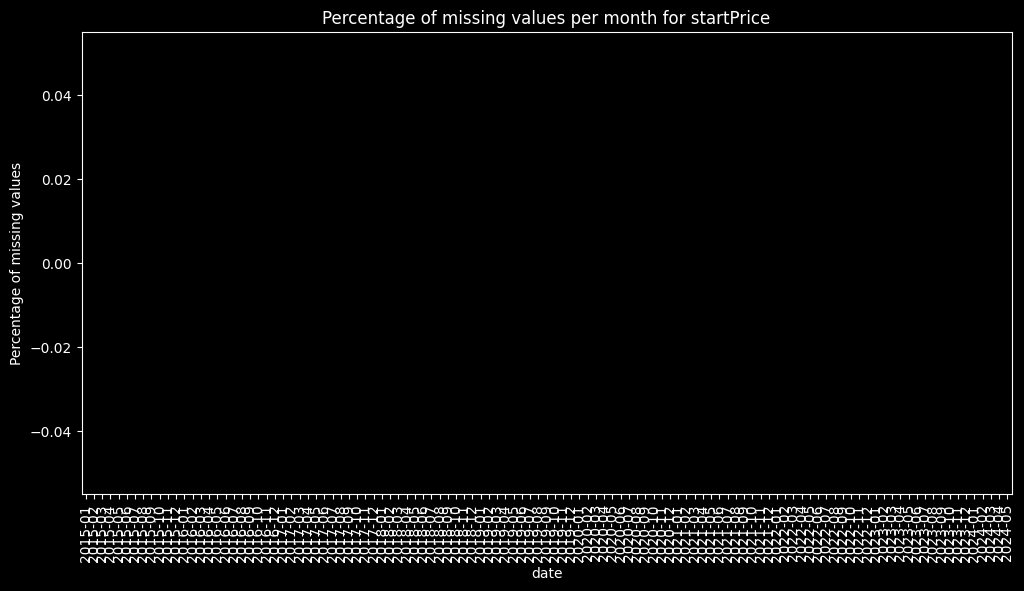

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: distance, Length: 113, dtype: float64


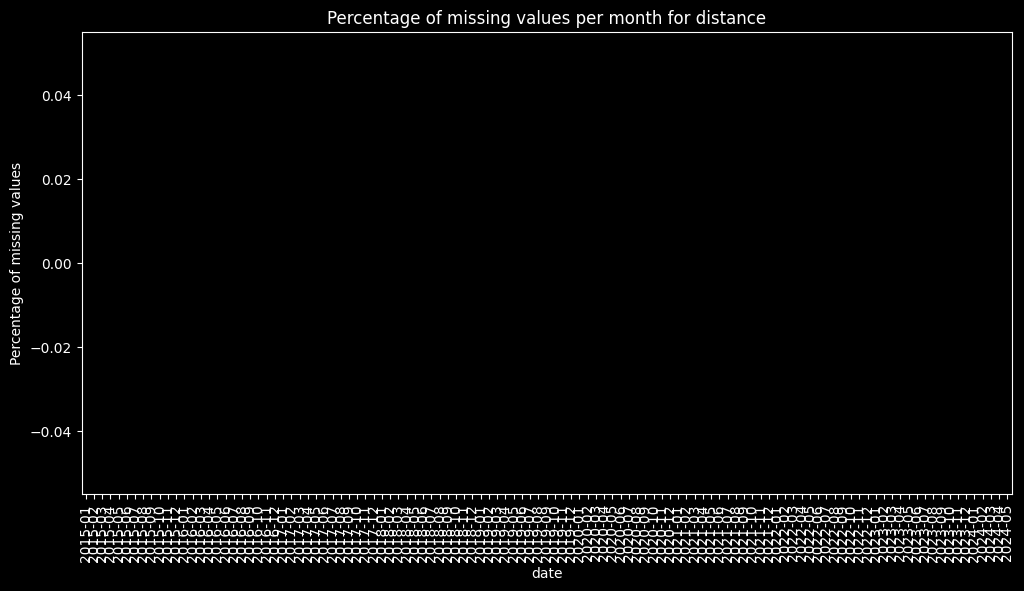

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: boxNumber, Length: 113, dtype: float64


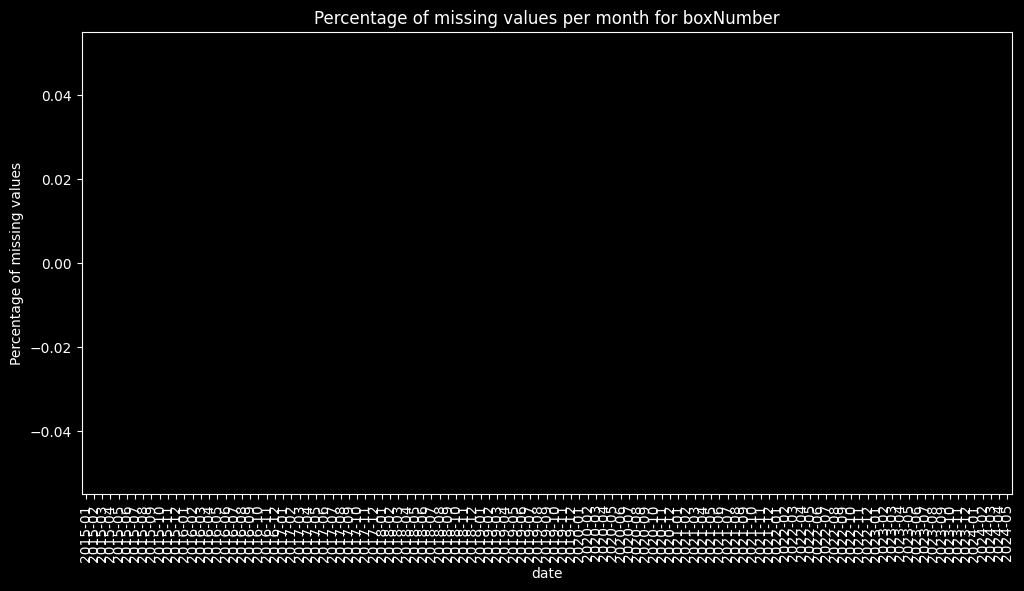

date
2015-01    19.655493
2015-02     3.887327
2015-03     1.144125
2015-04     0.098250
2015-05     0.136630
             ...    
2024-01     0.000000
2024-02     0.000000
2024-03     0.000000
2024-04     0.000000
2024-05     0.000000
Freq: M, Name: runTimeNorm, Length: 113, dtype: float64


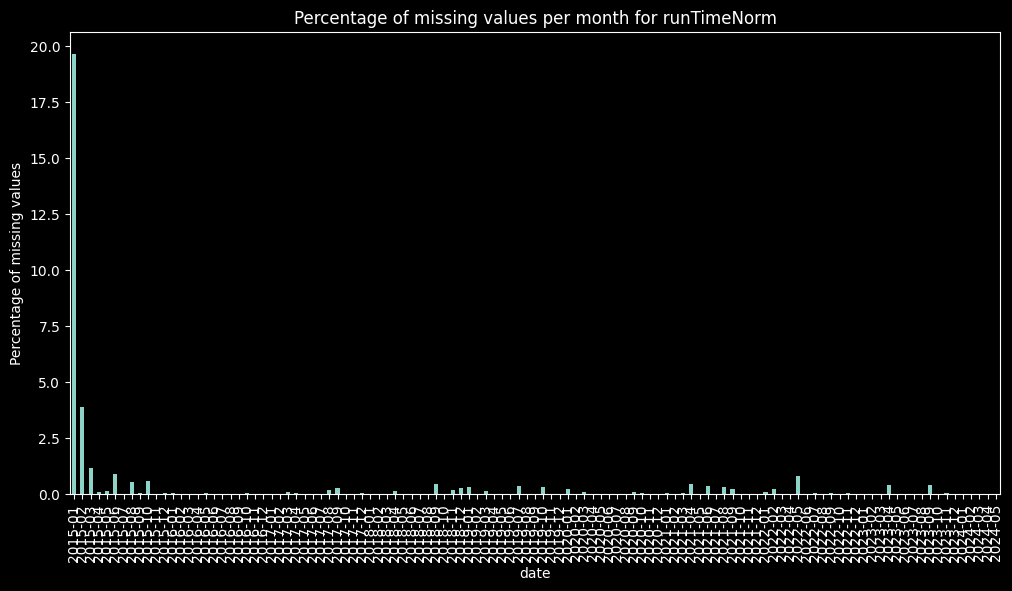

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: place, Length: 113, dtype: float64


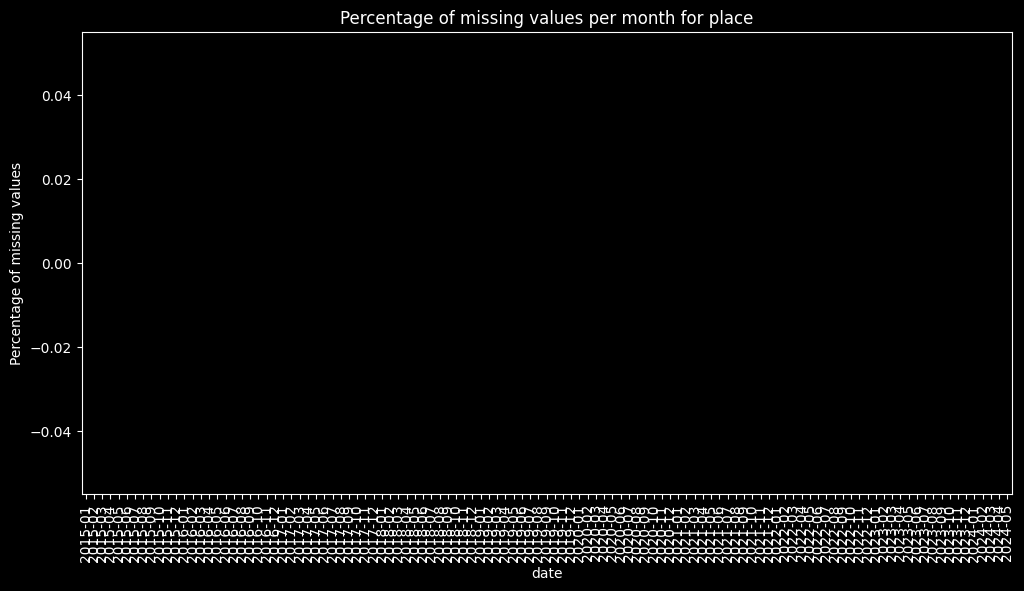

date
2015-01    0.079143
2015-02    0.039465
2015-03    0.060904
2015-04    0.056143
2015-05    0.042697
             ...   
2024-01    0.000000
2024-02    0.018216
2024-03    0.004321
2024-04    0.000000
2024-05    0.049685
Freq: M, Name: resultMargin, Length: 113, dtype: float64


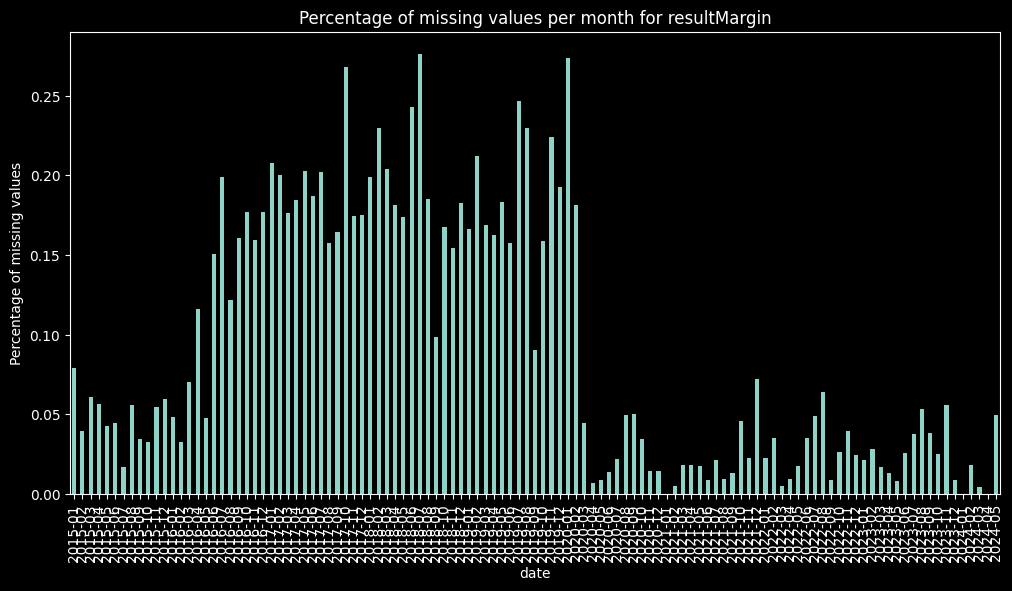

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: finishingPlaceMovement, Length: 113, dtype: float64


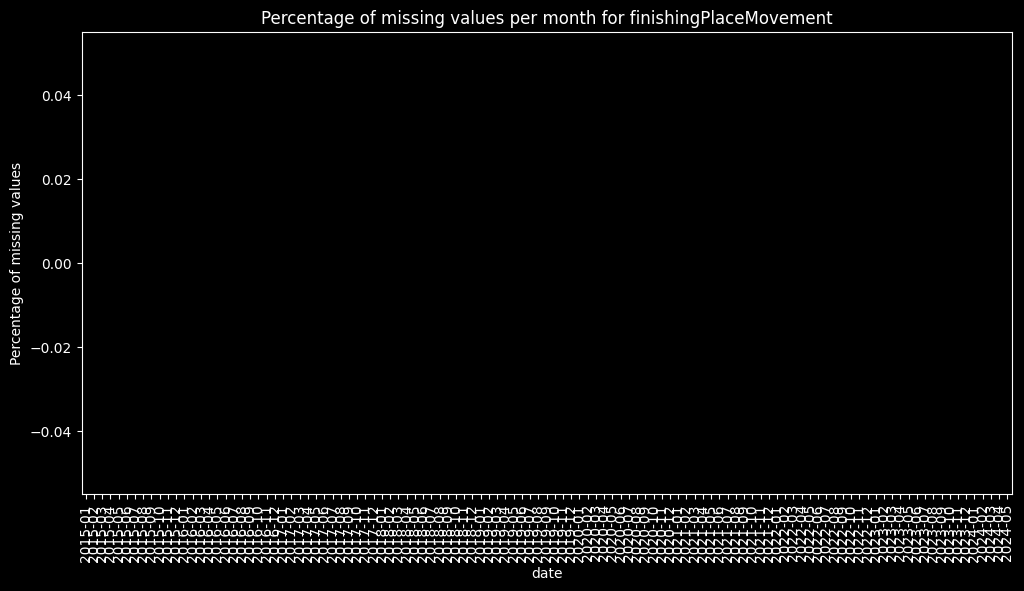

date
2015-01    0.004655
2015-02    0.000000
2015-03    0.000000
2015-04    0.000000
2015-05    0.000000
             ...   
2024-01    0.000000
2024-02    0.000000
2024-03    0.000000
2024-04    0.000000
2024-05    0.000000
Freq: M, Name: StartingPlaceMovement, Length: 113, dtype: float64


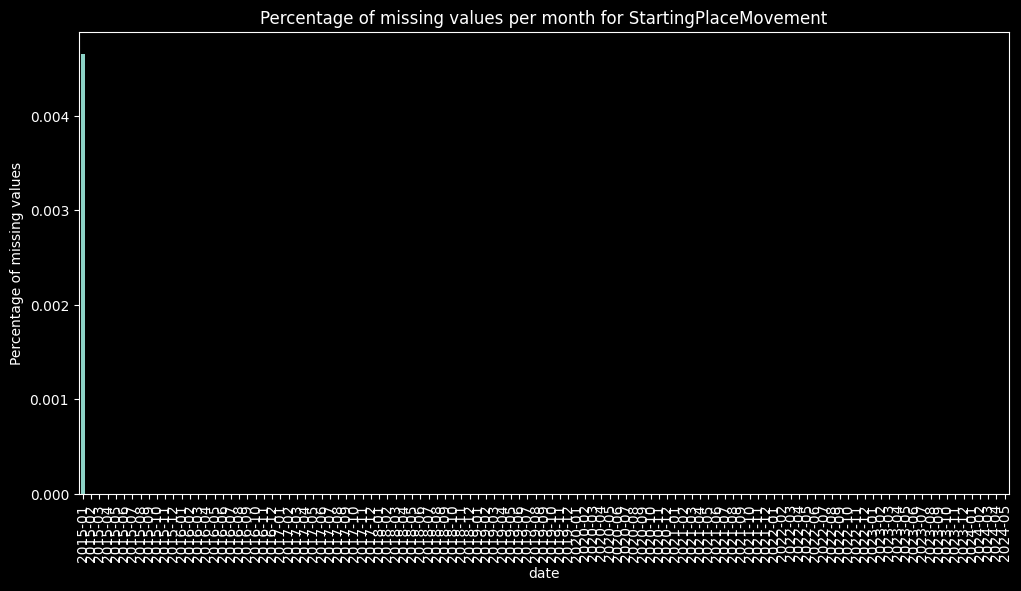

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: averageSpeed, Length: 113, dtype: float64


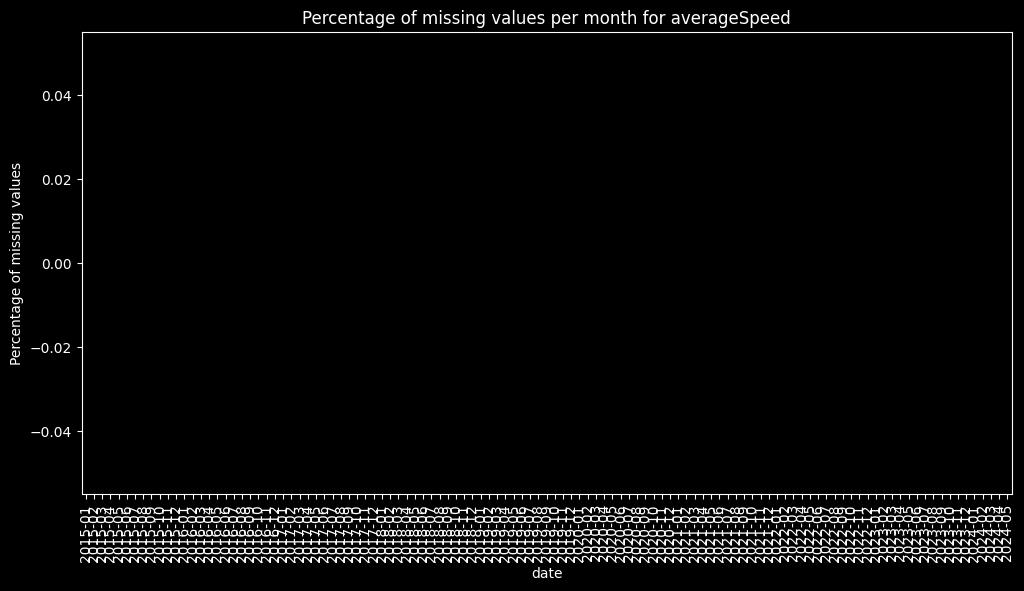

date
2015-01    0.0
2015-02    0.0
2015-03    0.0
2015-04    0.0
2015-05    0.0
          ... 
2024-01    0.0
2024-02    0.0
2024-03    0.0
2024-04    0.0
2024-05    0.0
Freq: M, Name: win, Length: 113, dtype: float64


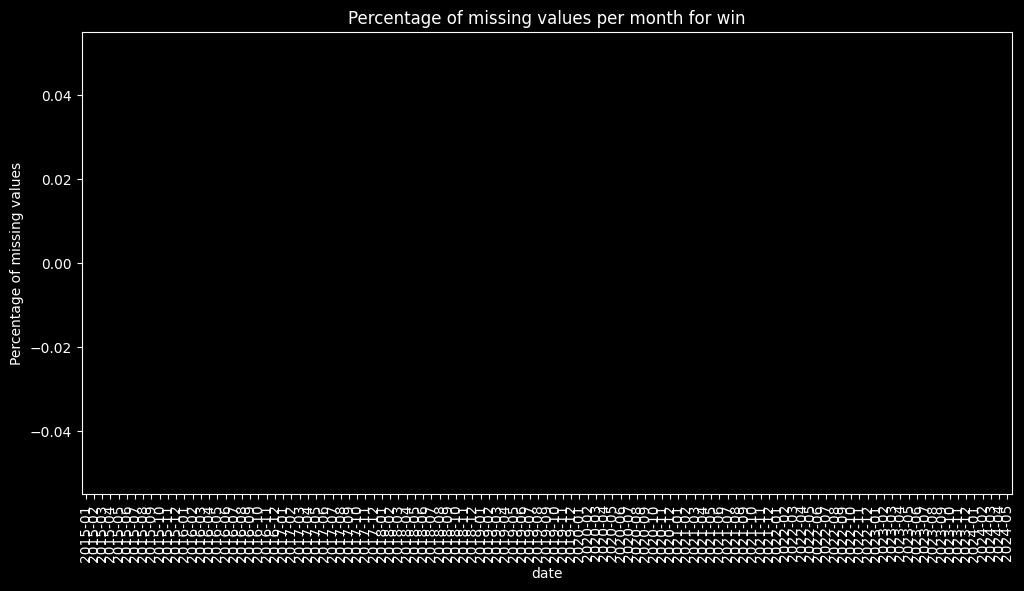

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your DataFrame and 'date' is your date column
df = TopazData.copy()
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')

# List of relevant columns
columns = ['startPrice','distance','boxNumber','runTimeNorm', 'place', 'resultMargin','finishingPlaceMovement','StartingPlaceMovement',
            'averageSpeed', 'win'] # replace with your actual column names

# Create a separate plot for each column
for col in columns:
    # Group by 'date' and calculate the percentage of missing values in each month for the column
    try:
        missing_data = df.groupby('date')[col].apply(lambda x: x.isnull().mean() * 100)
        print(missing_data)

        # Plot the results
        missing_data.plot(kind='bar', figsize=(12, 6))
        plt.title(f'Percentage of missing values per month for {col}')
        plt.ylabel('Percentage of missing values')
        plt.show()
    except Exception as e:
        print(e)

In [137]:
dataset.to_feather('topaz_data_dog.fth')

In [138]:
dataset.dogName

0             BUREKUP JACK
1           GALLOPING EMMA
2               DIEGONATOR
3                POPPY JAY
4             LEOPARDSTOWN
                ...       
2543670         HARD ON ME
2543671        IRISH NIKKI
2543672         RILEY COIN
2543673       CLASSY KAYLA
2543674    DAINTREE DAMAGE
Name: dogName, Length: 2543675, dtype: object

In [139]:
dataset = pd.read_feather('topaz_data_dog.fth')

In [140]:
betfair_df = pd.read_feather('../data_tools/DATA/df-betfairSP.fth')

In [141]:
betfair_df['date'] =  (pd.to_datetime(betfair_df['EVENT_DT'],dayfirst=True) + pd.Timedelta(hours=7)).dt.date
betfair_df['dogName'] = betfair_df.dog.str.strip().str.upper().str.replace('.','').replace("'",'')
# betfair_df.to_csv('betfair_bsp.csv')

In [142]:
dataset['date'] = pd.to_datetime(dataset['meetingDate']).dt.date
dataset['dogName'] = dataset['dogName'].str.upper().str.replace('.','').str.replace("'",'')

In [143]:
dataset_bsp = dataset.merge(betfair_df,on=['date','dogName'],how='left')

In [144]:
betfair_df.columns

Index(['EVENT_ID', 'EVENT_DT', 'SELECTION_ID', 'BSP', 'dog', 'MENU_HINT',
       'date', 'dogName'],
      dtype='object')

In [145]:
def generate_prev_race(df_in, df_g, rolling_window=10, factor=''):
    df = df_in.copy()
    original_cols = df_in.columns
    df[f'prev_race'] = df_g['raceId'].shift(1).fillna('-1').astype('string')
    df[f'prev_race_date'] = df_g['date'].shift(1).fillna('-1').astype('string')
    df[f'prev_race_track'] = df_g['track'].shift(1).fillna('-1').astype('string')
    df[f'prev_race_state'] = df_g['state'].shift(1).fillna('-1').astype('string')
    df[f'next_race'] = df_g['raceId'].shift(-1).fillna('-1').astype('string')
    df[f'prev_BSP_price'] = df_g['BSP'].shift(1).fillna(-1)
    df[f'prev_start_price'] = df_g['startPrice'].shift(1).fillna(-1)
    return(df)

In [146]:
dataset_bsp = generate_prev_race(dataset_bsp,dataset_bsp.groupby('dogId'))

In [147]:
feature_cols

['dogAgeScaled',
 'boxNumber',
 'incomingGrade_val',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_incomingGrade_val_mean_1',
 'dog_startPrice_mean_1',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_win_runTimeNorm_mean_1',
 'dog_delta_win_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_StartingPlaceMovement_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_performance_to_price_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'trainer_incomingGrade_val_mean_365D',
 'trainer_startPrice_mean_365D',
 'trainer_distance_mean_365D',
 'trainer_boxNumber_mean_365D',
 'trainer_runTimeNorm_mean_365D',
 'trainer_win_runTimeNorm_mean_365D',
 'trainer_delta_win_runTimeNorm_mean_365D',
 'trainer_place_mean_365D',
 'trainer_resultMargin_mean_3

In [148]:
len(feature_cols)

79

In [149]:
feature_cols[0:26]

['dogAgeScaled',
 'boxNumber',
 'incomingGrade_val',
 'weightInKgScaled',
 'hasEntryBoxNumberPlus1',
 'hasEntryBoxNumberMinus1',
 'rolling_box_win_percentage',
 'dog_incomingGrade_val_mean_1',
 'dog_startPrice_mean_1',
 'dog_distance_mean_1',
 'dog_boxNumber_mean_1',
 'dog_runTimeNorm_mean_1',
 'dog_win_runTimeNorm_mean_1',
 'dog_delta_win_runTimeNorm_mean_1',
 'dog_place_mean_1',
 'dog_resultMargin_mean_1',
 'dog_finishingPlaceMovement_mean_1',
 'dog_StartingPlaceMovement_mean_1',
 'dog_split_time_margin_mean_1',
 'dog_split_runTimeNorm_mean_1',
 'dog_time_1_mean_1',
 'dog_run_home_TimeNorm_mean_1',
 'dog_performance_to_price_mean_1',
 'dog_averageSpeed_mean_1',
 'dog_win_mean_1',
 'trainer_incomingGrade_val_mean_365D']

In [150]:
for i in dataset.columns:
    print(i)

meetingDate
state
track
distance
raceId
raceTypeCode
raceNumber
boxNumber
rugNumber
runId
dogId
dogName
weightInKg
sex
trainerId
trainerState
damId
damName
sireId
sireName
win
place
resultTime
resultMargin
resultMarginLengths
dogAgeScaled
startPrice
incomingGrade_val
weightInKgScaled
rolling_box_win_percentage
hasEntryBoxNumberPlus1
hasEntryBoxNumberMinus1
dog_incomingGrade_val_mean_1
dog_startPrice_mean_1
dog_distance_mean_1
dog_boxNumber_mean_1
dog_runTimeNorm_mean_1
dog_win_runTimeNorm_mean_1
dog_delta_win_runTimeNorm_mean_1
dog_place_mean_1
dog_resultMargin_mean_1
dog_finishingPlaceMovement_mean_1
dog_StartingPlaceMovement_mean_1
dog_split_time_margin_mean_1
dog_split_runTimeNorm_mean_1
dog_time_1_mean_1
dog_run_home_TimeNorm_mean_1
dog_performance_to_price_mean_1
dog_averageSpeed_mean_1
dog_win_mean_1
dog_incomingGrade_val_mean_365D
dog_startPrice_mean_365D
dog_distance_mean_365D
dog_boxNumber_mean_365D
dog_runTimeNorm_mean_365D
dog_win_runTimeNorm_mean_365D
dog_delta_win_runTimeN

In [151]:
dataset_bsp

,meetingDate,state,track,distance,raceId,raceTypeCode,raceNumber,boxNumber,rugNumber,runId,...,BSP,dog,MENU_HINT,prev_race,prev_race_date,prev_race_track,prev_race_state,next_race,prev_BSP_price,prev_start_price
0,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,1.0,1,-2147327190,...,4.350000,Burekup Jack,AUS / Sale (AUS) 8th Apr,-1,-1,-1,-1,135714891.0,-1.000000,-1.0
1,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,2.0,2,-2147327192,...,80.000000,Galloping Emma,AUS / Sale (AUS) 8th Apr,-1,-1,-1,-1,109257585.0,-1.000000,-1.0
2,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,3.0,3,-2147327188,...,11.451747,Diegonator,AUS / Sale (AUS) 8th Apr,-1,-1,-1,-1,111581227.0,-1.000000,-1.0
3,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,4.0,4,-2147327193,...,36.950095,Poppy Jay,AUS / Sale (AUS) 8th Apr,-1,-1,-1,-1,108046162.0,-1.000000,-1.0
4,2016-04-08 00:00:00+00:00,VIC,Sale,650,-2147337285,RW,4,6.0,6,-2147327191,...,3.606549,Leopardstown,AUS / Sale (AUS) 8th Apr,-1,-1,-1,-1,108336760.0,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544514,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,4.0,4,2147340371,...,21.754498,Hard On Me,Warragul (AUS) 24th Feb,1032318028.0,2024-05-14,Warragul,VIC,-1,60.000000,21.0
2544515,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,5.0,5,2147340370,...,5.800100,Irish Nikki,Warragul (AUS) 24th Feb,1028381661.0,2024-05-04,The Meadows,VIC,-1,8.200000,9.0
2544516,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,6.0,6,2147340375,...,100.000000,Riley Coin,Warragul (AUS) 24th Feb,1011633297.0,2024-03-31,Bendigo,VIC,-1,29.152778,24.0
2544517,2024-02-24 00:00:00+00:00,VIC,Warragul,400,2147330092,5F,9,7.0,7,2147340376,...,69.418061,Classy Kayla,Warragul (AUS) 24th Feb,1027690779.0,2024-05-02,Ballarat,VIC,-1,55.000000,12.0


In [152]:
stat_values =  pd.Series( dataset_bsp[feature_cols].fillna(-1.0).astype('float32').values.tolist())
dataset_bsp['stats_topaz'] = stat_values
dataset_bsp['dogid'] = dataset_bsp['dogId'].astype('str')
dataset_bsp['raceid'] = dataset_bsp['raceId'].astype('str')
dataset_bsp['stats_cols'] = str(feature_cols)

In [153]:
# dataset_bsp.to_feather('topaz_data_w_bsp.fth')

In [154]:
# dataset_bsp = pd.read_feather('topaz_data_w_bsp.fth')

In [155]:
def hash_trackname(trackname, hash_size=1024):
    hashes = [hash(x) % hash_size for x in trackname]
    return hashes

In [156]:
hashes = {x: hash(x)%1024 for x in dataset_bsp.track.unique()}

In [157]:
dataset_bsp['track_hash'] = dataset_bsp['track'].map(hashes)

In [158]:
dataset_bsp.to_feather('topaz_data_w_bsp_new7.fth')
aasdf

NameError: name 'aasdf' is not defined

: 

In [ ]:
dataset.query('raceId == 1025683863').BSP

AttributeError: 'DataFrame' object has no attribute 'BSP'

In [ ]:
dataset_bsp

In [ ]:
dataset_bsp.date.max()

datetime.date(2024, 5, 14)

In [ ]:
max = datetime(2024, 5, 13).date()

In [ ]:
dataset_bsp_preds = dataset_bsp[dataset_bsp['date'] >= max]

In [ ]:
dataset_bsp.columns

In [ ]:
dataset.query('raceId == 618363326').place

In [ ]:
len(dataset_bsp['stats_topaz'].iloc[0])

In [ ]:
df = dataset_bsp.copy()
col = 'BSP'
df = df[df['state']!='NZ']
df['date'] = pd.to_datetime(df['date']).dt.to_period('Y')
missing_data = df.groupby(['date','state'])[col].apply(lambda x: x.isnull().mean() * 100)

# Plot the results
missing_data.plot(kind='bar', figsize=(40, 6))
plt.title(f'Percentage of missing values per month for {col}')
plt.ylabel('Percentage of missing values')
plt.show()

In [ ]:
dataset = pd.read_feather('../data/topaz_data_w_bsp.fth')

In [ ]:
for i,c in enumerate(dataset.columns):
    print(i,c)

In [ ]:
dataset.to_csv('../data/topaz_data_w_bsp.csv')

In [ ]:
dataset.shape

In [ ]:
feature_cols

In [ ]:
for col in dataset.columns:
    print(col)

In [ ]:
feature_cols

In [ ]:
dataset.raceId.nunique()


In [ ]:
# Your existing function to generate date range
def generate_date_range(start_date, end_date):
    start_date = start_date
    end_date = end_date

    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(days=31)

    return date_list

# Example usage:
start_date = datetime(2024,1,1)
end_date = (datetime.today() + timedelta(days=31))

# Generate the date range
date_range = generate_date_range(start_date, end_date)

In [ ]:


def topaz_races_threaded(buckets, topaz_api, progress):
    all_races = []
    # print(f"{buckets=}")
    errors = []
    for bucket in buckets:
        start_date, end_date, state = bucket
        # print(bucket)
        try:
            races = topaz_api.get_races(from_date=start_date, to_date=end_date, owning_authority_code=state)
            races['state'] = state
            all_races.append(races)
        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
            errors.append(bucket)
            pass
        # time.sleep(2)
        progress.update()
    return all_races,errors

def get_topaz_races(start_date, end_date, states, topaz_api:TopazAPI):
    date_range = generate_date_range(start_date, end_date)
    starts = date_range[:-1]
    ends = date_range[1:]
    date_range_states = [(start, end, state) for start, end in zip(starts, ends) for state in states]

    print(f"Created {len(date_range_states)} date ranges for {len(states)} states")

    num_workers = min(6, len(date_range_states))  # Adjust this value based on your system's capabilities
    chunk_size = math.ceil(len(date_range_states) / num_workers)

    chunks = [date_range_states[i:i + chunk_size] for i in range(0, len(date_range_states), chunk_size)]
    
    print(chunks)
    print(len(chunks))
    _process_jobs = []
    bars = []
    results = []
    errors = []
    for i in range(num_workers):
        bars.append(tqdm(total=len(chunks[i]), position=i)) 
        # time.sleep(2)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:


        for i,chunk in enumerate(chunks):
            _process_jobs.append(executor.submit(topaz_races_threaded, chunk, topaz_api, bars[i]))

        # results = []
        for job in concurrent.futures.as_completed(_process_jobs):
            result,error = job.result()
            errors.extend(error)
            results.append(result)

    

    # results = []
    print(errors)
    return results

In [ ]:
start_date = datetime(2024,4,20)
end_date = (datetime.today() + timedelta(days=31))
states = states = ['NSW', 'VIC', 'NZ', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT']
states = ['NZ', "NSW", "VIC", "SA"]
# states = ['SA']

In [ ]:
output = get_topaz_races(start_date, end_date, states, topaz_api)
output_flat = [item for sublist in output for item in sublist]
all_races_df = pd.concat(output_flat,ignore_index=True).reset_index(drop=True)
all_races_df.to_csv('all_races_topas_NEW.csv',index=False)

NameError: name 'topaz_api' is not defined

In [ ]:
import torch
from torch import nn

# Assume you have 1000 unique track names and you want to create an embedding of size 50 for each track name
num_tracknames = 1000
embedding_dim = 50

# Create an embedding layer
embedding = nn.Embedding(num_tracknames, embedding_dim)

# Assume trackname_indices is a tensor of integers, where each integer is the index of a track name in the dictionary
# For example, you can create it by replacing each track name in your data with its index in the dictionary of track names
trackname_indices = torch.tensor([0, 1, 2, 3, 4])  # replace with your actual data

# Get the embeddings of the track names
trackname_embeddings = embedding(trackname_indices)

print(trackname_embeddings)

In [ ]:
all_races_df['date'] = pd.to_datetime(all_races_df['raceStart']).dt.date

In [ ]:
meeting_ids = list(all_races_df['meetingId'].unique())

In [ ]:
def topaz_meeting_runs_threaded(chunk,topaz_api:TopazAPI,progress):
    race_runs = []
    race_results = []
    errors = []
    for race_id in chunk:
        try:
            # race_run = topaz_api.get_race_runs(race_id=race_id)
            # race_runs.append(race_run)
            time.sleep(0.3)
            race_result_json = topaz_api.get_race_result(race_id = race_id)
            try:
                race_run.to_feather(f"race_runs/{race_id}_run.fth")
                race_result_df = pd.DataFrame.from_dict([race_result_json])
                race_result_df.to_feather(f"results/{race_id}_results.fth")
            except Exception as e:
                print(e)

        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
            if http_err.response.status_code == 429:

                time.sleep(120)
            errors.append(race_id)
            pass
        progress.update()

    return race_runs,race_results,errors

def topaz_meeting_run_getter(race_id_list,topaz_api:TopazAPI):

    print(f"Fetching data for  {len(race_id_list)}")

    num_workers = 6
    chunk_size = math.ceil(len(race_id_list) / num_workers)

    chunks = [race_id_list[i:i + chunk_size] for i in range(0, len(race_id_list), chunk_size)]
    
    print(chunks)
    print(len(chunks))
    _process_jobs = []
    bars = []
    race_runs = []
    results = []
    errors = []
    for i in range(num_workers):
        bars.append(tqdm(total=len(chunks[i]), position=i)) 
        # time.sleep(2)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:


        for i,chunk in enumerate(chunks):
            _process_jobs.append(executor.submit(topaz_meeting_runs_threaded, chunk, topaz_api, bars[i]))

        # results = []
        for job in concurrent.futures.as_completed(_process_jobs):
            race_run,result_json,error = job.result()
            race_runs.extend(race_run)
            errors.extend(error)
            results.extend(result_json)

    

    # results = []
    print(errors)
    return race_runs,results,errors

In [ ]:
race_ids = list(all_races_df['raceId'].unique())

In [ ]:
race_id = 837931333

In [ ]:
race_run = topaz_api.get_race_runs(race_id=race_id)
race_result_json,response = topaz_api.get_race_result(race_id=race_id)

In [ ]:
rate_lim_left = int(response.headers['ratelimit-remaining'])
reset_time = int(response.headers['ratelimit-reset'])

In [ ]:
reset_time

In [ ]:
race_run_from_json = pd.DataFrame(race_result_json['runs'])

In [ ]:
race_run_from_json 

In [ ]:
split_times = pd.DataFrame(race_result_json['splitTimes'])
split_times_1 = split_times[split_times['splitTimeMarker'] == 1][['runId','time','position','splitMargin']]
split_time_2 = split_times[split_times['splitTimeMarker'] == 2][['runId','time','position','splitMargin']]
split_times = split_times_1.merge(split_time_2, on='runId',suffixes=('_1','_2'),how='left')

In [ ]:
split_times

In [ ]:
race_run_from_json 

In [ ]:
race_result_json

In [ ]:
race_result_json_meeting = topaz_api.get_meeting_details(meeting_id = 809592457)

In [ ]:
race_result_df

In [ ]:
def topaz_race_runs_threaded(chunk,topaz_api:TopazAPI,progress):
    race_runs = []
    race_results = []
    errors = []
    for race_id in chunk:
        try:
            race_run = topaz_api.get_race_runs(race_id=race_id)
            race_runs.append(race_run)
            time.sleep(0.3)
            race_result_json = topaz_api.get_race_result(race_id = race_id)
            try:
                race_run.to_feather(f"race_runs/{race_id}_run.fth")
                race_result_df = pd.DataFrame.from_dict([race_result_json])
                race_result_df.to_feather(f"results/{race_id}_results.fth")
            except Exception as e:
                print(e)

        except requests.HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')
            if http_err.response.status_code == 429:

                time.sleep(120)
            errors.append(race_id)
            pass
        progress.update()

    return race_runs,race_results,errors

In [ ]:
def topaz_race_run_getter(race_id_list,topaz_api:TopazAPI):

    print(f"Fetching data for  {len(race_id_list)}")

    num_workers = 6
    chunk_size = math.ceil(len(race_id_list) / num_workers)

    chunks = [race_id_list[i:i + chunk_size] for i in range(0, len(race_id_list), chunk_size)]
    
    print(chunks)
    print(len(chunks))
    _process_jobs = []
    bars = []
    race_runs = []
    results = []
    errors = []
    for i in range(num_workers):
        bars.append(tqdm(total=len(chunks[i]), position=i)) 
        # time.sleep(2)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:


        for i,chunk in enumerate(chunks):
            _process_jobs.append(executor.submit(topaz_race_runs_threaded, chunk, topaz_api, bars[i]))

        # results = []
        for job in concurrent.futures.as_completed(_process_jobs):
            race_run,result_json,error = job.result()
            race_runs.extend(race_run)
            errors.extend(error)
            results.extend(result_json)

    

    # results = []
    print(errors)
    return race_runs,results,errors

In [ ]:
all_races_df = pd.read_csv('all_races_topas.csv', header=0)
i = 0
race_ids = list(all_races_df['raceId'].unique())
# subset_ids = race_ids[i:min(len(race_ids),i+100)]
# race_runs,results,errors = topaz_race_run_getter(subset_ids,topaz_api)

In [ ]:
all_races_df

In [ ]:
test_race_run_df = pd.read_feather('race_runs/837931333_run.fth')

In [ ]:
test_race_results_json_df = pd.read_feather('results/837931333_results.fth')

In [ ]:
test_race_results_json_df

In [ ]:
for i in range(0,len(race_ids),100):
    subset_ids = race_ids[i:min(len(race_ids),i+1000)]
    race_runs,results,errors = topaz_race_run_getter(subset_ids,topaz_api)

    results_df = pd.DataFrame.from_dict(results)
    all_race_runs = pd.concat(race_runs,ignore_index=True).reset_index(drop=True)
    all_race_runs.to_feather(f'race_runs/{i}_topaz_race_runs.fth')
    results_df.to_feather(f"results/{i}_topaz_results.fth")
    # with 

In [ ]:
results

In [ ]:
race_ids = list(all_races_df['raceId'].unique())
code = "NSW-VIC"
for race_id in tqdm(race_ids, desc="Processing races", unit="race"):
    result_retries = 10

    while result_retries > 0:
        # Use tqdm to create a progress bar
        # Get race run data
        try:
            race_run = topaz_api.get_race_runs(race_id=race_id)
            race_result_json = topaz_api.get_race_result(race_id=race_id)
            file_path = code + '_DATA.csv'
            file_exists = os.path.isfile(file_path)
            header_param = not file_exists

            race_result = pd.DataFrame.from_dict([race_result_json])
            split_times_df = pd.DataFrame(race_result['splitTimes'].tolist(),index=race_result.index)

            splits_dict = split_times_df.T.stack().to_frame()
            splits_dict.reset_index(drop=True, inplace= True)
            splits_normalised = pd.json_normalize(splits_dict[0])

            if len(splits_normalised) == 0:
                race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                break

            first_split = splits_normalised[splits_normalised['splitTimeMarker'] == 1]
            first_split = first_split[['runId','position','time']]
            first_split = first_split.rename(columns={'position':'firstSplitPosition','time':'firstSplitTime'})
            second_split = splits_normalised[splits_normalised['splitTimeMarker'] == 2]
            second_split = second_split[['runId','position','time']]
            second_split = second_split.rename(columns={'position':'secondSplitPosition','time':'secondSplitTime'})

            split_times = splits_normalised[['runId']]
            split_times = pd.merge(split_times,first_split,how='left',on=['runId'])
            split_times = pd.merge(split_times,second_split,how='left',on=['runId'])

            race_run = pd.merge(race_run,split_times,how='left',on=['runId'])
            race_run.drop_duplicates(inplace=True)
            race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
            break
        except requests.HTTPError as http_err:
            if http_err.response.status_code == 404:
                file_path = code + '_DATA.csv'
                file_exists = os.path.isfile(file_path)
                header_param = not file_exists
                race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                break
        except Exception as e:
            print(race_id)
            result_retries -= 1
            if result_retries > 0:
                time.sleep(15)
            else:
                time.sleep(120)

In [ ]:
# Iterate over 7-day blocks
for i in range(0, len(date_range), 10):
    start_block_date = date_range[i]
    print(start_block_date)
    end_block_date = date_range[min(i + 9, len(date_range) - 1)]  # Ensure the end date is within the range

    codes = ['NT','VIC','NSW','SA','WA','QLD','TAS','NZ']
    codes = ['VIC', "NSW"]
    all_races = []
    for code in codes:
        
        print(code)
        retries = 10  # Number of retries
        while retries > 0:
            try:
                races = topaz_api.get_races(from_date=start_block_date, to_date=end_block_date, owning_authority_code=code)
                all_races.append(races)
                break  # Break out of the loop if successful
            except requests.HTTPError as http_err:
                if http_err.response.status_code == 429:
                    retries -= 1
                    if retries > 0:
                        print(f"Rate limited. Retrying in 121 seconds...")
                        time.sleep(121)
                    else:
                        print("Max retries reached. Moving to the next block.")
                else:
                    print(f"Error fetching races for {code}: {http_err.response.status_code}")
                    retries -= 1
                    if retries > 0:
                        print(f"Retrying in 30 seconds...")
                        time.sleep(30)
                    else:
                        print("Max retries reached. Moving to the next block.")

    try:
        all_races_df = pd.concat(all_races,ignore_index=True).reset_index(drop=True)
    except ValueError:
        continue

    # Extract unique race IDs
    race_ids = list(all_races_df['raceId'].unique())

    for race_id in tqdm(race_ids, desc="Processing races", unit="race"):
        result_retries = 10

        while result_retries > 0:
            # Use tqdm to create a progress bar
            # Get race run data
            try:
                race_run = topaz_api.get_race_runs(race_id=race_id)
                race_result_json = topaz_api.get_race_result(race_id=race_id)
                file_path = code + '_DATA.csv'
                file_exists = os.path.isfile(file_path)
                header_param = not file_exists

                race_result = pd.DataFrame.from_dict([race_result_json])
                split_times_df = pd.DataFrame(race_result['splitTimes'].tolist(),index=race_result.index)

                splits_dict = split_times_df.T.stack().to_frame()
                splits_dict.reset_index(drop=True, inplace= True)
                splits_normalised = pd.json_normalize(splits_dict[0])

                if len(splits_normalised) == 0:
                    race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                    break

                first_split = splits_normalised[splits_normalised['splitTimeMarker'] == 1]
                first_split = first_split[['runId','position','time']]
                first_split = first_split.rename(columns={'position':'firstSplitPosition','time':'firstSplitTime'})
                second_split = splits_normalised[splits_normalised['splitTimeMarker'] == 2]
                second_split = second_split[['runId','position','time']]
                second_split = second_split.rename(columns={'position':'secondSplitPosition','time':'secondSplitTime'})

                split_times = splits_normalised[['runId']]
                split_times = pd.merge(split_times,first_split,how='left',on=['runId'])
                split_times = pd.merge(split_times,second_split,how='left',on=['runId'])

                race_run = pd.merge(race_run,split_times,how='left',on=['runId'])
                race_run.drop_duplicates(inplace=True)
                race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                break
            except requests.HTTPError as http_err:
                if http_err.response.status_code == 404:
                    file_path = code + '_DATA.csv'
                    file_exists = os.path.isfile(file_path)
                    header_param = not file_exists
                    race_run.to_csv(code + '_DATA.csv', mode='a', header=header_param, index=False)
                    break
            except Exception as e:
                print(race_id)
                result_retries -= 1
                if result_retries > 0:
                    time.sleep(15)
                else:
                    time.sleep(120)